## Using the N-Body Method

Having written an n-body right hand side function and bound the gravitational acceleration, lets try it out!

Begin by resurrecting your ode code and doing some runs with initial conditions provided below. We know our best bet will be the Euler-Richardson algorithm. Integrate through 100 time units and plot the result.

I've left plotting code to save you some time with that.

For each of the initial conditions, find the maximum allowable time step the allows visually acceptable repeating orbits for 100 time steps. Record those time steps for future reference.

After completing that exercise, implement the fourth order Runge Kutta algorithm as part of your ODE solving function and repeat the above exercise. Are you doing better in terms of time steps? What about the number of function calls.

**Note:** I've tried to save you the hassle of writing plotting code. I figure you've done enough of that this semester. The problem is, I don't think mine is especially tidy. If you feel like replacing mine with something better, by all means, go for it.

### Runge Kutta

The simplest but steadiest performance can be realized with the *fourth order Runge-Kutta* integration methods. The following equations haver errors of order $\mathcal{O}(\Delta t^5)$. They can be expressed as.

$$
\begin{align}
k_1 &=& &\Delta t f(t_n,y_n)\\
k_2 &=& &\Delta t f(t_n + \frac{1}{2}\Delta t,y_n + \frac{1}{2} k_1)\\
k_3 &=& &\Delta t f(t_n + \frac{1}{2}\Delta t,y_n + \frac{1}{2} k_2)\\
k_4 &=& &\Delta t f(t_n + \frac{1}{2}\Delta t,y_n +  k_3)
\end{align}
$$

$$y_{n+1} = y_n + \frac{1}{6} k_1 + \frac{1}{3} k_2 + \frac{1}{3} k_3 + \frac{1}{6} k_4 $$

In [1]:
import numpy as np

def Euler(dt, f, t, y, args):
    return y + (f(t, y, *args) * dt)

def EulerRichardson(dt, f, t, y, args):
    y_n = Euler(dt / 2, f, t, y, args)
    return y + (dt * f(t + (dt / 2), y_n, *args))

def solve_ode(f, tspan, y0, method=EulerRichardson, args=(), **options):
    t0 = tspan[0]
    tf = tspan[1]
    dt = options.get("first_step", 0.01)
    y = [np.asarray(y0)]
    t = [t0]
    i = 1
    while t[-1] < tf:
        y.append(method(dt, f, t[-1], y[-1], args))
        t.append(t0 + dt * i)
        i += 1
    y = np.array(y)
    return np.array(t), y

def n_body(t, y, p):
    '''
    Write what goes in here!
    Instructions above.
    '''
    d = p["dimension"]
    N = len(y) // (2 * d)
    fix_first = p["fix_first"]
    masses = p["m"]
    G = p["G"]
    dydt = np.zeros_like(y)
    half = len(y) // 2
    dydt[:half] = y[half:]
    F = np.zeros((d, N, N))
    
    for i in range(0, half, d):
        ifc = i // d
        mi = masses[ifc]
        ri = y[i:i + d]
        for j in range(i + d, half, d):
            rj = y[j:j + d]
            rij = ri - rj
            jfc = j // d
            mj = masses[jfc]
            fij = -G * mi * mj * rij / np.linalg.norm(rij)**3
            F[:, ifc, jfc] = fij / mi
            F[:, jfc, ifc] = -fij / mj
    dydt[half:] = F.sum(axis=2).T.ravel() 
    if fix_first:
        dydt[:d] = 0
        dydt[half:half + d] = 0
    return dydt

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import namedtuple
from IPython.display import HTML
from matplotlib.animation import FuncAnimation


Body = namedtuple("Body", ("x", "y"))


def solution_to_bodies(y, d):
    n = len(y[0]) // (2 * d)
    bodies = [Body(y[:, i], y[:, i + 1]) for i in range(0, n * d, d)]
    return bodies


class SolutionAnimation:
    def __init__(self, t, y, figsize=None, interval=10, title=None):
        self.t = t
        self.y = y
        self.bodies = solution_to_bodies(y, 2)

        self.interval = interval

        plt.style.use("dark_background")
        self.fig = plt.figure(figsize=figsize)
        if title is not None:
            self.ax.set_title(title)
        self.ax = self.fig.add_subplot(111)
        self.ax.axes.get_xaxis().set_visible(False)
        self.ax.axes.get_yaxis().set_visible(False)
        plt.axis("equal")
        self.interval = interval
        self.paused = False

    def init(self):
        self.artists = []
        self.traces = []
        self.tails = []
        self.positions = []
        self.body_colors = []
        # Plot body traces
        for b in self.bodies:
            (trace,) = self.ax.plot(b.x, b.y, color="darkgray", lw=0.5)
            self.traces.append(trace)
        # Plot trailing tail
        for b in self.bodies:
            (tail,) = self.ax.plot(b.x[:1], b.y[:1])
            color = tail.get_color()
            self.body_colors.append(color)
            self.artists.append(tail)
            self.tails.append(tail)
        # Plot bodies
        for b, c in zip(self.bodies, self.body_colors):
            (pos,) = self.ax.plot(b.x[:1], b.y[:1], "o", color=c)
            self.artists.append(pos)
            self.positions.append(pos)
        return self.artists

    def update(self, i):
        for b, tail in zip(self.bodies, self.tails):
            tail.set_data(
                b.x[max(0, i - 20) : i + 1], b.y[max(0, i - 20) : i + 1]
            )
        for b, pos in zip(self.bodies, self.positions):
            pos.set_data(b.x[i : i + 1], b.y[i : i + 1])
        return self.artists

    def on_click(self, event):
        """Toggle play/pause with space bar. Handy for non-jupyter runs."""
        if event.key != " ":
            return
        if self.paused:
            self.ani.event_source.start()
            self.paused = False
        else:
            self.ani.event_source.stop()
            self.paused = True

    def run(self):
        self.fig.canvas.mpl_connect("key_press_event", self.on_click)
        self.ani = FuncAnimation(
            self.fig,
            self.update,
            frames=len(self.t),
            init_func=self.init,
            interval=self.interval,
            repeat=False,
            blit=False,
        )
        return self

    def to_vid(self):
        return HTML(self.ani.to_html5_video())

In [20]:
import numpy as np
# Order is all coordinates then all velocities in groups by mass:
# x1,y1,x2,y2,x3,y3,vx1,vy1,vx2,vy2,etc
euler      = np.array([0,0,1,0,-1,0,0,0,0,.8,0,-.8])

montgomery = np.array([0.97000436,-0.24308753,-0.97000436,0.24308753, 0., 0.,\
                    0.466203685, 0.43236573, 0.466203685, 0.43236573,\
                   -0.93240737,-0.86473146])
lagrange   = np.array([1.,0.,-0.5,0.866025403784439, -0.5,-0.866025403784439,\
                  0.,0.8,-0.692820323027551,-0.4, 0.692820323027551, -0.4])

p3 = {'m':[1,1,1],'G':1,'dimension':2,'fix_first':False}

## Euler

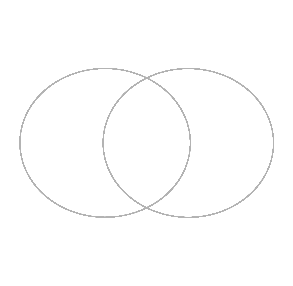

In [21]:
y0 = euler
p  = p3
d = p["dimension"]
dt = 0.001  # This is wrong - figure it out!
t_span = [0,100]

t_s,y = solve_ode(n_body,t_span, y0, EulerRichardson, args=(p,), first_step=dt)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

x_min,x_max,y_min,y_max = 1e9,-1e9,1e9,-1e9
for i in range(0,y0.size//d,d):
    x_t = y[:,i]
    y_t = y[:,i+1]
    if x_min > x_t.min(): x_min = x_t.min()
    if x_max < x_t.max(): x_max = x_t.max()
    if y_min > y_t.min(): y_min = y_t.min()
    if y_max < y_t.max(): y_max = y_t.max()

    ph, =  ax.plot(x_t,y_t,'-',color=[.7,.7,.7],linewidth=.5) 

plt.xlim([1.2*x_min,1.2*x_max])
plt.ylim([1.2*y_min,1.2*y_max])

plt.axis("equal")
ax.axis('off')
plt.show()

(100001, 12)


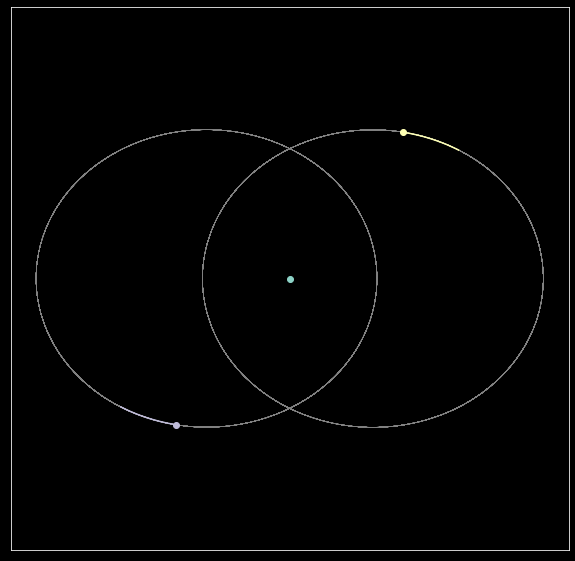

In [23]:
SolutionAnimation(t_s[::10], y[::10], figsize=(10, 10)).run().to_vid()

## Montgomery

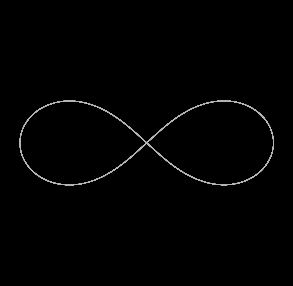

In [27]:
y0 = montgomery
p  = p3
d = p["dimension"]
dt = 0.01  # This is wrong - figure it out!
t_span = [0,100]

t_s,y = solve_ode(n_body,t_span, y0, EulerRichardson, args=(p,), first_step=dt)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

x_min,x_max,y_min,y_max = 1e9,-1e9,1e9,-1e9
for i in range(0,y0.size//d,d):
    x_t = y[:,i]
    y_t = y[:,i+1]
    if x_min > x_t.min(): x_min = x_t.min()
    if x_max < x_t.max(): x_max = x_t.max()
    if y_min > y_t.min(): y_min = y_t.min()
    if y_max < y_t.max(): y_max = y_t.max()

    ph, =  ax.plot(x_t,y_t,'-',color=[.7,.7,.7],linewidth=.5) 

plt.xlim([1.2*x_min,1.2*x_max])
plt.ylim([1.2*y_min,1.2*y_max])

plt.axis("equal")
ax.axis('off')
plt.show()

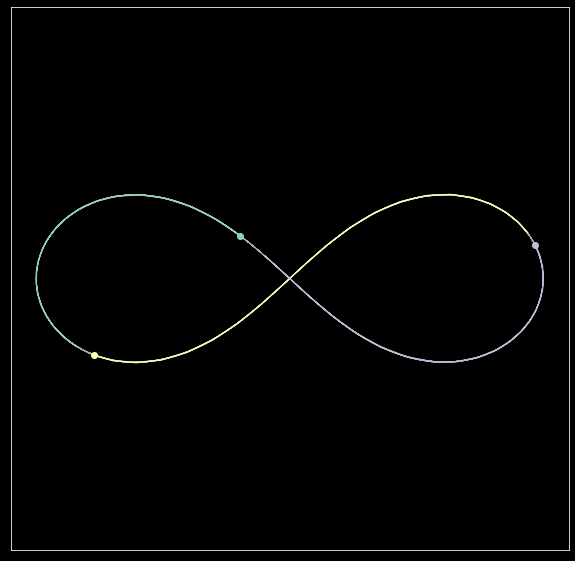

In [31]:
SolutionAnimation(t_s[::10], y[::10], figsize=(10, 10), interval=30).run().to_vid()

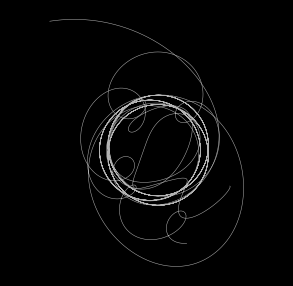

In [34]:
y0 = lagrange
p  = p3
d = p["dimension"]
dt = 0.0001  # This is wrong - figure it out!
t_span = [0,100]

t_s,y = solve_ode(n_body,t_span, y0, EulerRichardson, args=(p,), first_step=dt)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

x_min,x_max,y_min,y_max = 1e9,-1e9,1e9,-1e9
for i in range(0,y0.size//d,d):
    x_t = y[:,i]
    y_t = y[:,i+1]
    if x_min > x_t.min(): x_min = x_t.min()
    if x_max < x_t.max(): x_max = x_t.max()
    if y_min > y_t.min(): y_min = y_t.min()
    if y_max < y_t.max(): y_max = y_t.max()

    ph, =  ax.plot(x_t,y_t,'-',color=[.7,.7,.7],linewidth=.5) 

plt.xlim([1.2*x_min,1.2*x_max])
plt.ylim([1.2*y_min,1.2*y_max])

plt.axis("equal")
ax.axis('off')
plt.show()

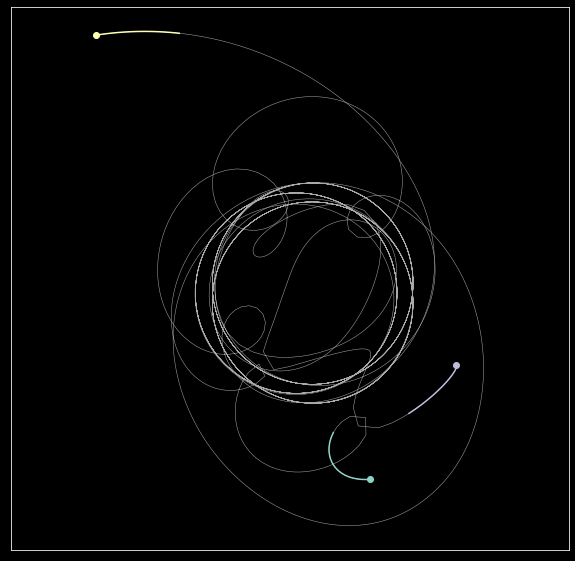

In [37]:
SolutionAnimation(t_s[::1000], y[::1000], figsize=(10, 10), interval=30).run().to_vid()